In [1]:
## Test trained GAN models 
from tensorflow.keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
from numpy.random import randn
import tensorflow as tf
import cv2
import numpy as np

In [2]:
model_name = 'bi_gru_model_039207.h5'
dataset_name  = './dual_condition_dataset_test.npz'

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# Overlay trajectories (data_y) to the image (data_x)
def create_trajectory(data_x, data_y, obs_len=10):
    # Calibration parameter to overlay for a 1280x360 resolution image
    K = np.array([[537.023764, 0, 640 , 0], 
                    [0 , 537.023764, 180, 0], 
                    [0, 0, 1, 0]])
    # Rotation matrix to obtain egocentric trajectory
    Rt = np.array([[0.028841, 0.007189, 0.999558, 1.481009],
                    [-0.999575,  0.004514,  0.028809,  0.296583],
                    [ 0.004305,  0.999964, -0.007316, -1.544537],
                    [ 0.      ,  0.      ,  0.      ,  1.      ]])

    # Resize data back to 1280x360
    data_x = cv2.resize(data_x, (1280,360))
    # Add column of ones for rotation matrix multiplication
    data_y = np.hstack((data_y, np.ones((len(data_y),1))))
    # Draw points
    for m in range(obs_len, data_y.shape[0]):
        # Rotation matrix multiplication of trajectory 
        A = np.matmul(np.linalg.inv(Rt), data_y[m, :].reshape(4, 1))
        # Egocentric view of trajectory
        B = np.matmul(K, A)
        # Circle location of trajectories 
        x = int(B[0, 0] * 1.0 / B[2, 0])
        y = int(B[1, 0] * 1.0 / B[2, 0])
        if (x < 0 or x > 1280 - 1 or y > 360 - 1):
            continue
        # Use opencv to overlay trajectories
        data_x = cv2.circle(data_x, (x, y), 3, (0, 0, 255), -1)
    return data_x

In [5]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [6]:
def generate_drvact_text(drvact):
    text = '[warnings] drvact label is not defined ...'
    if (drvact == 1):
        text = 'Go'
    elif (drvact == 2):
        text = 'Turn Left'
    elif (drvact == 3):
        text = 'Turn Right'
    elif (drvact == 4):
        text = 'U-turn'
    elif (drvact == 5):
        text = 'Left LC'
    elif (drvact == 6):
        text = 'Right LC'
    elif (drvact == 7):
        text = 'Avoidance'
    return text

In [7]:
# plot source, generated and target images
def plot_images(X_realA, X_fakeB, X_realB, filename, n_samples=1):
    X_realA = (X_realA + 1) / 2.0
    titles = ['Source', 'Generated', 'Expected']
    pyplot.figure(figsize=(32.0, 20.0))
    # plot real source images
    for i in range(n_samples):
        orig_image = (X_realA[i]* 255).astype(np.uint8)
        orig_image = cv2.resize(orig_image, (1280,360))
        pyplot.subplot(3, n_samples, 1 + i)
        # pyplot.axis('off')
        pyplot.imshow(orig_image)
        pyplot.title(titles[i])
    # plot generated target image
    pyplot.text(10,20, 'Driver Action: ' + generate_drvact_text(label+1), color='red', fontsize=12, fontweight='extra bold')
    for i in range(n_samples):
        fake_sample = create_trajectory((X_realA[i]* 255).astype(np.uint8), X_fakeB[i])
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(fake_sample)
        pyplot.title(titles[1 + i])
    # plot real target image
    for i in range(n_samples):
        true_sample = create_trajectory((X_realA[i]* 255).astype(np.uint8), X_realB[i])
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(true_sample)
        pyplot.title(titles[i + 2])
    # save plot to file
    pyplot.subplots_adjust(hspace=0.4)
    pyplot.show()
    pyplot.savefig(filename)
    # save the generator model

In [8]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	return [X1, X2]

In [9]:
# load dataset
#data = load('./dual_condition_dataset_train.npz')
data = load(dataset_name)
# unpack arrays
X1, X2, X3 = data['arr_0'], data['arr_1'], data['arr_2']
X3 = X3-1

In [10]:
# load model
model = load_model(model_name)
#model = load_model('./model_033606.h5')

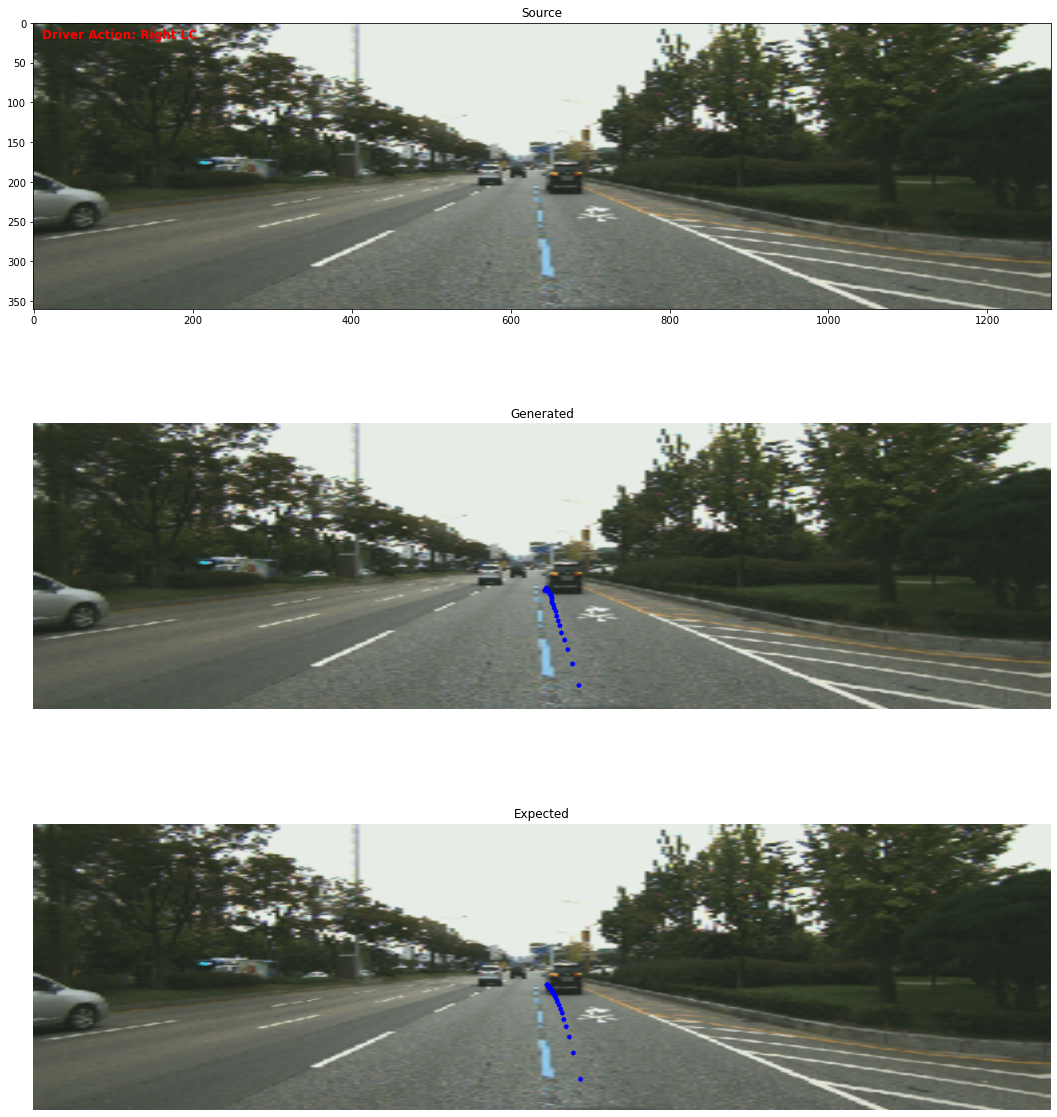

<Figure size 432x288 with 0 Axes>

In [11]:
# select random example
latent_dim = 512
z_input = generate_latent_points(latent_dim, 1)
ix = int(randint(0, len(X1), 1))
#ix = 4290
src_image, tar_traj, label = X1[ix].reshape((1, 256, 256, 3)), X2[ix].reshape((1,40,3)), X3[ix].reshape(1)
# generate image from source
gen_traj = model.predict([src_image, z_input, label])
plot_images(src_image, gen_traj, tar_traj, 'sample20.png')

In [12]:
import math
def euclidean_distance(p1, p2):
    return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 + (p2[2] - p1[2])**2)

In [13]:
#params: traj1, traj2 - sets of two trajectories which the ADE is requires
#returns: Average Displacement Error between two trajectories
#brief: takes two traj. of same size, returns the average euclidean distance between all points of traj1 and traj2
def ADE(traj1, traj2):
    try:
        assert(traj1.shape == traj2.shape)
    except AssertionError:
        print("trajectory arrays differ in size!")
        return None
    dist = []
    points = len(traj1[0])
    #print(f'{points} long')
    for itr in range(points):
        p1 = traj1[0][itr]
        p2 = traj2[0][itr]
        dist.append(euclidean_distance(p1, p2))
        #print(f'traj1: {p1}, traj2: {p2}, dist: {dist[itr]}')
    ade = sum(dist)/len(dist)
    #print(ade)
    return ade

In [14]:
#params: traj1, traj2 - sets of two trajectories which the FDE is requires
#returns: Final Displacement Error between two trajectories
#brief: takes two traj. of same size, returns the euclidean distance between final points of traj1 and traj2
def FDE(traj1, traj2):
    try:
        assert(traj1.shape == traj2.shape)
    except AssertionError:
        print("trajectory arrays differ in size!")
        return None
    last_idx = len(traj1[0]) - 1
    #print(f'last index is {last_idx}')
    p1 = traj1[0][last_idx]
    p2 = traj2[0][last_idx]
    fde = euclidean_distance(p1, p2)
    #print(f'traj1: {p1}, traj2: {p2}, dist: {fde}')
    #print(fde)
    return fde

In [15]:
def get_stats(num_trajs=100, latent_dim=512, z_input=generate_latent_points(latent_dim, 1)):
    minADE = float('inf')
    minFDE = float('inf')
    avgADE = []
    avgFDE = []
    for img in range(num_trajs):
        ix = img
        src_image, tar_traj, label = X1[ix].reshape((1, 256, 256, 3)), X2[ix].reshape((1,40,3)), X3[ix].reshape(1)
        # generate image from source
        gen_traj = model.predict([src_image, z_input, label])
        #plot_images(src_image, gen_traj, tar_traj, 'sample6.png')
        fde = FDE(tar_traj, gen_traj)
        ade = ADE(tar_traj, gen_traj)
        #print(f'image: {img}, FDE: {fde}, ADE: {ade}')
        
        #minADE
        minADE = ade if ade < minADE else minADE
        
        #minFDE
        minFDE = fde if fde < minFDE else minFDE
        
        #avgADE
        avgADE.append(ade)
        
        #avgFDE
        avgFDE.append(fde)
        
    return(minADE, minFDE, sum(avgADE)/len(avgADE), sum(avgFDE)/len(avgFDE))

In [16]:
%%time
minADE, minFDE, avgADE, avgFDE = get_stats(num_trajs=len(X1))
print(f'minADE = {minADE}')
print(f'minFDE = {minFDE}')
print(f'avgADE = {avgADE}')
print(f'avgFDE = {avgFDE}')

minADE = 0.18218381377419085
minFDE = 0.13847771086309163
avgADE = 4.015263536090799
avgFDE = 9.868926791345869
CPU times: user 2min 30s, sys: 3.44 s, total: 2min 33s
Wall time: 2min 22s
